In [1]:
import pandas as pd 

In [7]:
data = pd.read_csv('kp_ap_since_1932.txt', skiprows=29, sep='\s+', header=0, index_col=False)
sndata = pd.read_csv('SN_d_tot_V2.0.txt', error_bad_lines=False, skiprows=1, sep='\s+', header=None, index_col=False)

/var/folders/l9/y8y3rmys2sl93tzzph3dl7jw0000gr/T/ipykernel_24152/754058082.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  sndata = pd.read_csv('SN_d_tot_V2.0.txt', error_bad_lines=False, skiprows=1, sep='\s+', header=None, index_col=False)
b'Skipping line 75150: expected 7 fields, saw 8\nSkipping line 75151: expected 7 fields, saw 8\nSkipping line 75152: expected 7 fields, saw 8\nSkipping line 75153: expected 7 fields, saw 8\nSkipping line 75154: expected 7 fields, saw 8\nSkipping line 75155: expected 7 fields, saw 8\nSkipping line 75156: expected 7 fields, saw 8\nSkipping line 75157: expected 7 fields, saw 8\nSkipping line 75158: expected 7 fields, saw 8\nSkipping line 75159: expected 7 fields, saw 8\nSkipping line 75160: expected 7 fields, saw 8\nSkipping line 75161: expected 7 fields, saw 8\nSkipping line 75162: expected 7 fields, saw 8\nSkipping line 75163: expected 7 fields, saw 8\n

In [3]:
len(data[data['Kp'] > 4])* 100 / len(data)

9.576957361461893

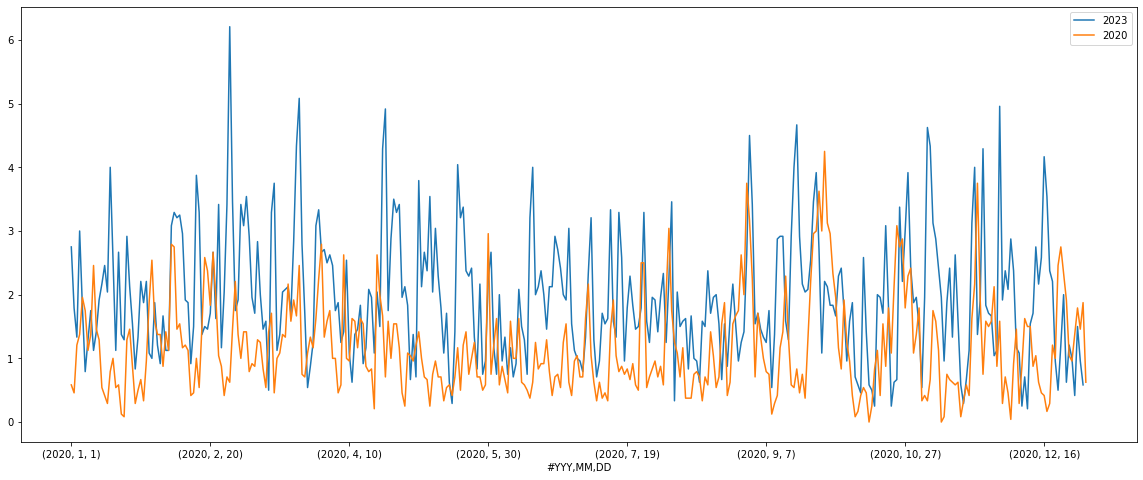

In [58]:
plt.figure(figsize=(20, 8))

year1 = 2023
daily_avgs = data[data['#YYY'] == year1].groupby(['#YYY', 'MM', 'DD']).mean()['Kp']
daily_avgs.plot(label=year1)
year2 = 2020
daily_avgs = data[data['#YYY'] == year2].groupby(['#YYY', 'MM', 'DD']).mean()['Kp']
daily_avgs.plot(label=year2)
plt.legend()

<AxesSubplot:xlabel='#YYY,MM,DD'>

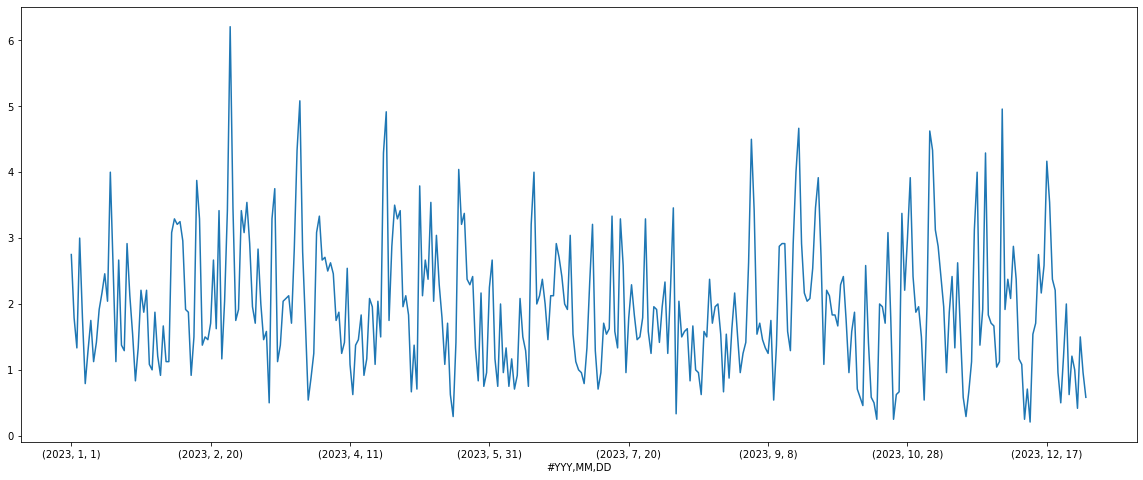

In [53]:
plt.figure(figsize=(20, 8))
daily_avgs.plot()

In [46]:
data['significant'] = data['Kp'] > 4
data[data['significant']][-50:]

,#YYY,MM,DD,hh.h,hh._m,days,days_m,Kp,ap,D,significant
268039,2023,9,24,21.0,22.5,33504.875,33504.9375,5.667,67,2,True
268040,2023,9,25,0.0,1.5,33505.000,33505.0625,5.333,56,2,True
268041,2023,9,25,3.0,4.5,33505.125,33505.1875,4.667,39,2,True
268050,2023,9,26,6.0,7.5,33506.250,33506.3125,4.667,39,2,True
268051,2023,9,26,9.0,10.5,33506.375,33506.4375,4.667,39,2,True
268052,2023,9,26,12.0,13.5,33506.500,33506.5625,5.000,48,2,True
268121,2023,10,5,3.0,4.5,33515.125,33515.1875,5.000,48,1,True
268249,2023,10,21,3.0,4.5,33531.125,33531.1875,4.667,39,1,True
268250,2023,10,21,6.0,7.5,33531.250,33531.3125,5.000,48,1,True
268294,2023,10,26,18.0,19.5,33536.750,33536.8125,4.333,32,1,True


In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# 1. Load the data
data = load_iris(as_frame=True)
X    = data['data']
y    = data['target']

# 2. Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 3. Instantiate a model
model = KNeighborsClassifier()

# 4. Fit a model
model.fit(X_train, y_train)

# 5. Predict on the test set
preds = model.predict(X_test)

# 6. Print classification report
print(classification_report(y_test, preds))

,#YYY,MM,DD,hh.h,hh._m,days,days_m,Kp,ap,D
0,1932,1,1,0.0,1.5,0.000,0.0625,3.333,18,1
1,1932,1,1,3.0,4.5,0.125,0.1875,2.667,12,1
2,1932,1,1,6.0,7.5,0.250,0.3125,2.333,9,1
3,1932,1,1,9.0,10.5,0.375,0.4375,2.667,12,1
4,1932,1,1,12.0,13.5,0.500,0.5625,3.333,18,1


In [13]:
sndata.columns = ['year', 'month', 'day', 'dec_year', 'sn_value', 'sn_error', 'obs_num']

In [14]:
sndata.head()

,year,month,day,dec_year,sn_value,sn_error,obs_num
0,1818,1,1,1818.001,-1,-1.0,0
1,1818,1,2,1818.004,-1,-1.0,0
2,1818,1,3,1818.007,-1,-1.0,0
3,1818,1,4,1818.010,-1,-1.0,0
4,1818,1,5,1818.012,-1,-1.0,0


In [21]:
sndata.shape, data.shape

((75148, 7), (269240, 10))

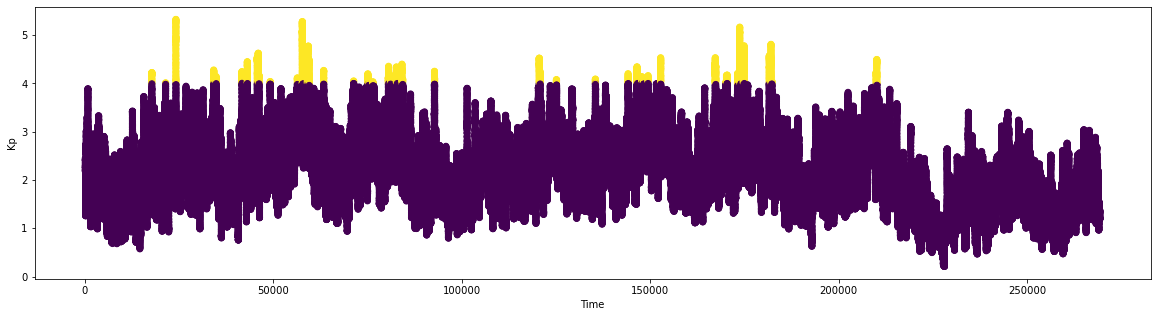

In [41]:
from matplotlib import pyplot as plt 
plt.figure(figsize=(20, 5))

avgs = data['Kp'].rolling(100).mean()
# plt.plot(data.index, data['Kp'].rolling(100).mean());
# plt.scatter(data.index, data['Kp'].rolling(100).mean(), c=data['Kp']>6);
plt.scatter(avgs.index, avgs, c=avgs>4);
plt.ylabel('Kp');
plt.xlabel('Time');

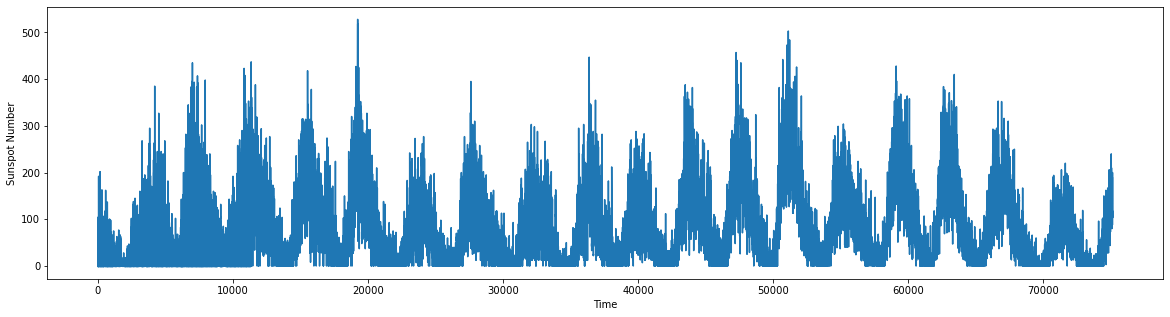

In [26]:
from matplotlib import pyplot as plt 
plt.figure(figsize=(20, 5))

plt.plot(sndata.index, sndata['sn_value']);
plt.ylabel('Sunspot Number');
plt.xlabel('Time');